##### Подготовка к работе с данными

In [37]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as matcol
import numpy as np
import seaborn as sns
from dotenv import load_dotenv
from pathlib import Path

##### Получаем данные по API

In [38]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

##### Данные по визитам

In [39]:
visits_json = requests.get('https://data-charts-api.hexlet.app/visits?begin=2022-03-01&end=2023-09-01').json()
#visits_json=requests.get(f'{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}')
visits_df = pd.DataFrame(visits_json)
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])

##### Данные по регистрациям

In [40]:
reg_json = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2022-03-01&end=2023-09-01').json()
#reg_json=requests.get(f'{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}')
regestrations_df = pd.DataFrame(reg_json)
regestrations_df['datetime'] = pd.to_datetime(regestrations_df['datetime'])

##### Очистка данных визитов от ботов и группировка по датам и платформам

In [41]:
def get_visits(df_v):
    prep_df = df_v.copy()
    prep_df['user_agent'] = prep_df['user_agent'].astype('str').replace('AdsBot-Google (+http://www.google.com/adsbot.html)', np.NaN)
    prep_df['user_agent'] = prep_df['user_agent'].astype('str').replace('Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)', np.NaN)
    prep_df['user_agent'] = prep_df['user_agent'].astype('str').replace('Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)', np.NaN)
    prep_df['user_agent'] = prep_df['user_agent'].astype('str').replace('Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.5359.130 Mobile Safari/537.36 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)', np.NaN)
    prep_df = prep_df.dropna()
    # оставляем только последние посещения
    prep_df = prep_df.sort_values(by='datetime', ascending=False).drop_duplicates(subset='visit_id')
    prep_df['datetime'] = prep_df['datetime'].dt.to_period('D').dt.start_time.dt.date
    prep_df = prep_df.groupby(['datetime', 'platform']).agg({'visit_id': 'count'}).reset_index()
    # Переименуем столбцы
    prep_df = prep_df.rename(columns={'datetime': 'date_group','visit_id': 'visits'})
    return prep_df

visits = get_visits(visits_df)
visits

,date_group,platform,visits
0,2023-03-01,android,75
1,2023-03-01,ios,22
2,2023-03-01,web,279
3,2023-03-02,android,67
4,2023-03-02,ios,31
...,...,...,...
589,2023-08-30,ios,66
590,2023-08-30,web,1227
591,2023-08-31,android,57
592,2023-08-31,ios,50


##### Очистка данных регистраций от ботов и группировка по датам и платформам

In [42]:
def get_regs(df_r):
    prep_df = df_r.copy()
    prep_df['datetime'] = prep_df['datetime'].dt.to_period('D').dt.start_time.dt.date
    prep_df = prep_df.sort_values('datetime').groupby(['datetime', 'platform']).agg({'user_id': 'count'}).reset_index()
    # Переименуем столбцы
    prep_df = prep_df.rename(columns={'datetime': 'date_group', 'user_id': 'registrations'})
    return prep_df

registrations = get_regs(regestrations_df)
registrations
    

,date_group,platform,registrations
0,2023-03-01,android,61
1,2023-03-01,ios,18
2,2023-03-01,web,8
3,2023-03-02,android,59
4,2023-03-02,ios,24
...,...,...,...
547,2023-08-30,ios,40
548,2023-08-30,web,34
549,2023-08-31,android,42
550,2023-08-31,ios,36


##### Соединение датасетов и расчет конверсий

In [43]:
def merged_df(visits, registrations):
    merged_df = pd.merge(visits, registrations, left_on=['date_group', 'platform'], right_on=['date_group', 'platform'])
    merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits'] * 100)
    merged_df.to_json('./conversion.json', orient='columns')
    return merged_df

conversions = merged_df(visits, registrations)

##### Загружаем и обрабатываем данные из файла ads.csv

In [44]:
#ads_df = pd.read_csv(path)
ads_df = pd.read_csv('./ads.csv')

##### Обработка колонки date

In [45]:
def get_ads(df):
    prep_ads = df.copy()
    prep_ads['date'] = pd.to_datetime(prep_ads['date'], format='mixed')
    prep_ads['date'] = prep_ads['date'].dt.to_period('D').dt.start_time.dt.date
    prep_ads = prep_ads.rename(columns={'date': 'date_group'})
    return prep_ads

prep_ads = get_ads(ads_df)

##### Объединим датафремы conversion и ads

In [46]:

merged_ads = pd.merge(
    conversions, prep_ads,
    left_on='date_group',
    right_on='date_group',
    how='inner'
)

##### Удаляем лишние столбцы и заполняем пропуски

In [47]:
clear_ads = merged_ads.drop(['platform', 'conversion', 'utm_source', 'utm_medium'], axis=1)
filled_ads = clear_ads.fillna({'utm_campaign': 'none', 'cost': 0})

##### Группируем и сортируем данные 

In [48]:
ads = filled_ads.sort_values('date_group').groupby(['date_group', 'utm_campaign']).sum().reset_index()
# Изменяем порядок столбцов
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
ads['utm_campaign'].unique()

array(['advanced_algorithms_series', 'virtual_reality_workshop',
       'ui_ux_design_drive', 'women_in_tech_symposium',
       'intro_to_python_course'], dtype=object)

##### Конверсия датафрейма в JSON

In [49]:
ads.to_json('./ads.json', orient='columns')

### Построение графиков

##### Подготовка данных для визуализации

In [50]:
def get_weekly_data(df1, df2):
    temp_weekly_conv1 = df1.copy()
    temp_weekly_conv2 = df2.copy()

    temp_weekly_conv1['date_week'] = pd.to_datetime(temp_weekly_conv1['date_group'])
    temp_weekly_conv1['date_week'] = temp_weekly_conv1['date_week'].dt.to_period('W').dt.start_time.dt.date

    temp_weekly_conv2['date_week'] = pd.to_datetime(temp_weekly_conv2['date_group'])
    temp_weekly_conv2['date_week'] = temp_weekly_conv2['date_week'].dt.to_period('W').dt.start_time.dt.date

    weekly_conv_platform = temp_weekly_conv2.groupby(['date_week', 'platform']).sum(['visits', 'registrations']).reset_index()
    weekly_conv = temp_weekly_conv1.groupby(['date_week']).sum(['visits', 'registrations']).reset_index()

    weekly_conv_platform['conversion'] = (weekly_conv_platform['registrations']/weekly_conv_platform['visits']) * 100
    weekly_conv = (weekly_conv['registrations']/weekly_conv['visits']) * 100
    return weekly_conv, weekly_conv_platform

weekly_conv, weekly_conv_platform = get_weekly_data(ads, conversions)

##### Создание директории charts

In [51]:
p = Path.cwd()
d = p / 'charts'
d.mkdir(exist_ok=True)

##### Построение графика Total visits

In [52]:
def total_visits(df):
    fig, ax = plt.subplots(figsize=(18, 9), tight_layout=True)
    bars = plt.bar(x='date_week', height='visits', data=weekly_conv_platform, width=5)
    #ax.bar_label(bars)
    plt.title('Total visits', fontsize=16)
    plt.xlabel('Date_group', fontsize=14)
    plt.ylabel('Visits', fontsize=14)
    plt.xticks(df['date_week'], rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"./charts/total_visits.png")
    plt.close(fig)

total_visits(weekly_conv_platform)

##### Построение графика Visits by Platform

In [53]:
def total_visits_by_platform(df):
    fig, ax = plt.subplots(figsize=(18, 9), tight_layout=True)
    df = df.pivot_table(index='date_week', columns='platform', values='visits')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Visits by Platform', fontsize=16)
    plt.xlabel('Date_group',fontsize=14)
    plt.ylabel('Visits',fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.savefig(f"./charts/Total_visits_platform.png")
    plt.close(fig)

total_visits_by_platform(weekly_conv_platform)


##### Построение графика Total registrations

In [54]:
def total_registrations(df):
    fig, ax = plt.subplots(figsize=(18,9), tight_layout=True)
    bars = plt.bar(x='date_week', height='registrations', data=weekly_conv_platform, width=5)
    #ax.bar_label(bars)
    plt.title('Total registrations', fontsize=16)
    plt.xlabel('Date_group', fontsize=14)
    plt.ylabel('Registrations', fontsize=14)
    plt.xticks(df['date_week'], rotation=45)
    plt.grid(axis='y')
    plt.savefig(f"./charts/Total_registrations.png")
    plt.close(fig)

total_registrations(weekly_conv_platform)

##### Построение графика Total registrations by platform

In [55]:
def total_registrations_platform(df):
    fig, ax = plt.subplots(figsize=(18,9), tight_layout=True)
    df = df.pivot_table(index='date_week', columns='platform', values='registrations')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Total Registrations by Platform', fontsize=16)
    plt.xlabel('Date_group', fontsize=14)
    plt.ylabel('Registrations', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.savefig(f"./charts/Total_registrations_by_platform.png")
    plt.close(fig)
    

total_registrations_platform(weekly_conv_platform)

##### Круговая диаграмма по типау регистраций

In [56]:
registrations_by_platform = conversions.groupby('platform')['registrations'].sum().reset_index()

In [57]:
def pie_chart_for_registrations(df):
    fig, ax = plt.subplots()
    ax.pie(df['registrations'], labels=registrations_by_platform['platform'], autopct='%1.1f%%')
    ax.axis('equal')
    plt.title('Registrations by Platform')
    plt.savefig(f"./charts/Pie_chart_for_reg.png")
    plt.close(fig)


pie_chart_for_registrations(registrations_by_platform)

##### Построение графиков конверсий по платформам

In [58]:
def get_conv_by_plat(df):
    visregconv = df.copy(deep=True)

    android_data = visregconv[visregconv['platform'] == 'android']
    ios_data = visregconv[visregconv['platform'] == 'ios']
    web_data = visregconv[visregconv['platform'] == 'web']

    fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=False, sharey=False, tight_layout=True)

    axs[0].plot(android_data['date_week'], android_data['conversion'], label='Android')
    axs[0].set_title('Conversion Android', fontsize=16)
    axs[0].set_ylabel('Conversion (%)', fontsize=14)
    axs[0].legend()
    axs[0].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
    axs[0].tick_params(axis='x', rotation=45)  
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))

    axs[1].plot(ios_data['date_week'], ios_data['conversion'], label='iOS')
    axs[1].set_title('Conversion iOS', fontsize=16)
    axs[1].set_ylabel('Conversion (%)', fontsize=14)
    axs[1].legend()
    axs[1].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
    axs[1].tick_params(axis='x', rotation=45) 
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(nbins=30)) 

    axs[2].plot(web_data['date_week'], web_data['conversion'], label='Web')
    axs[2].set_title('Conversion Web', fontsize=16)
    axs[2].set_xlabel('Date_group', fontsize=14)
    axs[2].set_ylabel('Conversion (%)', fontsize=14)
    axs[2].legend()
    axs[2].grid(True, linestyle='-', linewidth=2, alpha=0.5, which='both', axis='y', markevery=2)
    axs[2].tick_params(axis='x', rotation=45) 
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(nbins=30))

    plt.savefig(f"./charts/Conversion_platform_chart.png")

    plt.close(fig)

get_conv_by_plat(weekly_conv_platform)

##### Построим график средней конверсии

In [59]:
def avg_conversion(df):
    avg_conv_chart = df.groupby('date_week')['conversion'].mean()
    avg_conv_chart.plot(figsize=(18,9), style='o-', grid=True)
    plt.title('Average Conversion')
    plt.xlabel('Date_group')
    plt.ylabel('Conversion (%)')
    plt.xticks(df['date_week'].unique(), rotation=45)
    plt.savefig(f"./charts/Avg_conversion.png")
    plt.close()

avg_conversion(weekly_conv_platform)

##### Построение графиков стоимости рекламных кампаний

In [60]:
ads_week = ads.copy()
ads_week['date_week'] = pd.to_datetime(ads_week['date_group'])
ads_week['date_week'] = ads_week['date_week'].dt.to_period('W').dt.start_time.dt.date
ads_week = ads_week.groupby(['date_week', 'utm_campaign']).sum(['visits', 'registrations', 'cost']).reset_index()
ads_week['conversion'] = (ads_week['registrations'] / ads_week['visits']) * 100

In [61]:
def adscosts(df):
    adcosts = df.groupby('date_week')['cost'].mean().reset_index()
    fig, ax = plt.subplots()
    fig.set_size_inches(18,9)
    x = adcosts['date_week']
    y = adcosts['cost']
    ax.plot(x, y,
            marker="o",
            c="g",
            label='Стоимость реклам',
            linewidth=1.5,
            markersize=6)
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Cost')
    ax.grid(axis='y')
    plt.title('Aggregated Ad Campaign Costs')
    plt.xticks(adcosts['date_week'], rotation=45)
    plt.savefig(f"./charts/Adcosts.png")
    plt.close(fig)
adscosts(ads_week)

#### Построение графика с визитами и регистрацией с разбивкой по кампаниям

In [62]:
ads_week

,date_week,utm_campaign,visits,registrations,cost,conversion
0,2023-02-27,advanced_algorithms_series,3026,574,3462,18.968936
1,2023-03-06,advanced_algorithms_series,8615,1184,3516,13.743471
2,2023-03-13,advanced_algorithms_series,3065,438,1494,14.290375
3,2023-03-20,virtual_reality_workshop,1078,172,1773,15.955473
4,2023-03-27,virtual_reality_workshop,4958,856,3861,17.265026
5,2023-04-03,virtual_reality_workshop,5797,1058,4761,18.250819
6,2023-04-10,virtual_reality_workshop,4967,978,4647,19.689954
7,2023-04-17,virtual_reality_workshop,5700,973,4050,17.070175
8,2023-04-24,virtual_reality_workshop,5861,1063,3810,18.136837
9,2023-05-01,virtual_reality_workshop,4337,798,4191,18.399816


In [63]:
#['advanced_algorithms_series', 'virtual_reality_workshop', 'ui_ux_design_drive', 'women_in_tech_symposium', 'intro_to_python_course']

In [64]:
camp_days = ads_week[['date_week', 'utm_campaign']]

advanced_algorithms_series = camp_days.loc[camp_days['utm_campaign'] == 'advanced_algorithms_series']
start_date = advanced_algorithms_series['date_week'].min()
end_date = advanced_algorithms_series['date_week'].max()

virtual_reality_workshop = camp_days.loc[camp_days['utm_campaign'] == 'virtual_reality_workshop']
start_date = virtual_reality_workshop['date_week'].min()
end_date = virtual_reality_workshop['date_week'].max()

ui_ux_design_drive = camp_days.loc[camp_days['utm_campaign'] == 'ui_ux_design_drive']
start_date = ui_ux_design_drive['date_week'].min()
end_date = ui_ux_design_drive['date_week'].max()

women_in_tech_symposium = camp_days.loc[camp_days['utm_campaign'] == 'women_in_tech_symposium']
start_date = women_in_tech_symposium['date_week'].min()
end_date = women_in_tech_symposium['date_week'].max()

intro_to_python_course = camp_days.loc[camp_days['utm_campaign'] == 'intro_to_python_course']
start_date = intro_to_python_course['date_week'].min()
end_date = intro_to_python_course['date_week'].max()

periods_of_ads = pd.DataFrame(columns=['start_date', 'end_date', 'utm_campaign'])
periods_of_ads['start_date'] = [advanced_algorithms_series['date_week'].min(), virtual_reality_workshop['date_week'].min(), ui_ux_design_drive['date_week'].min(), women_in_tech_symposium['date_week'].min(), intro_to_python_course['date_week'].min()]
periods_of_ads['end_date'] = [advanced_algorithms_series['date_week'].max(), virtual_reality_workshop['date_week'].max(), ui_ux_design_drive['date_week'].max(), women_in_tech_symposium['date_week'].max(), intro_to_python_course['date_week'].max()]
periods_of_ads['utm_campaign'] = ['advanced_algorithms_series', 'virtual_reality_workshop', 'ui_ux_design_drive', 'women_in_tech_symposium', 'intro_to_python_course']


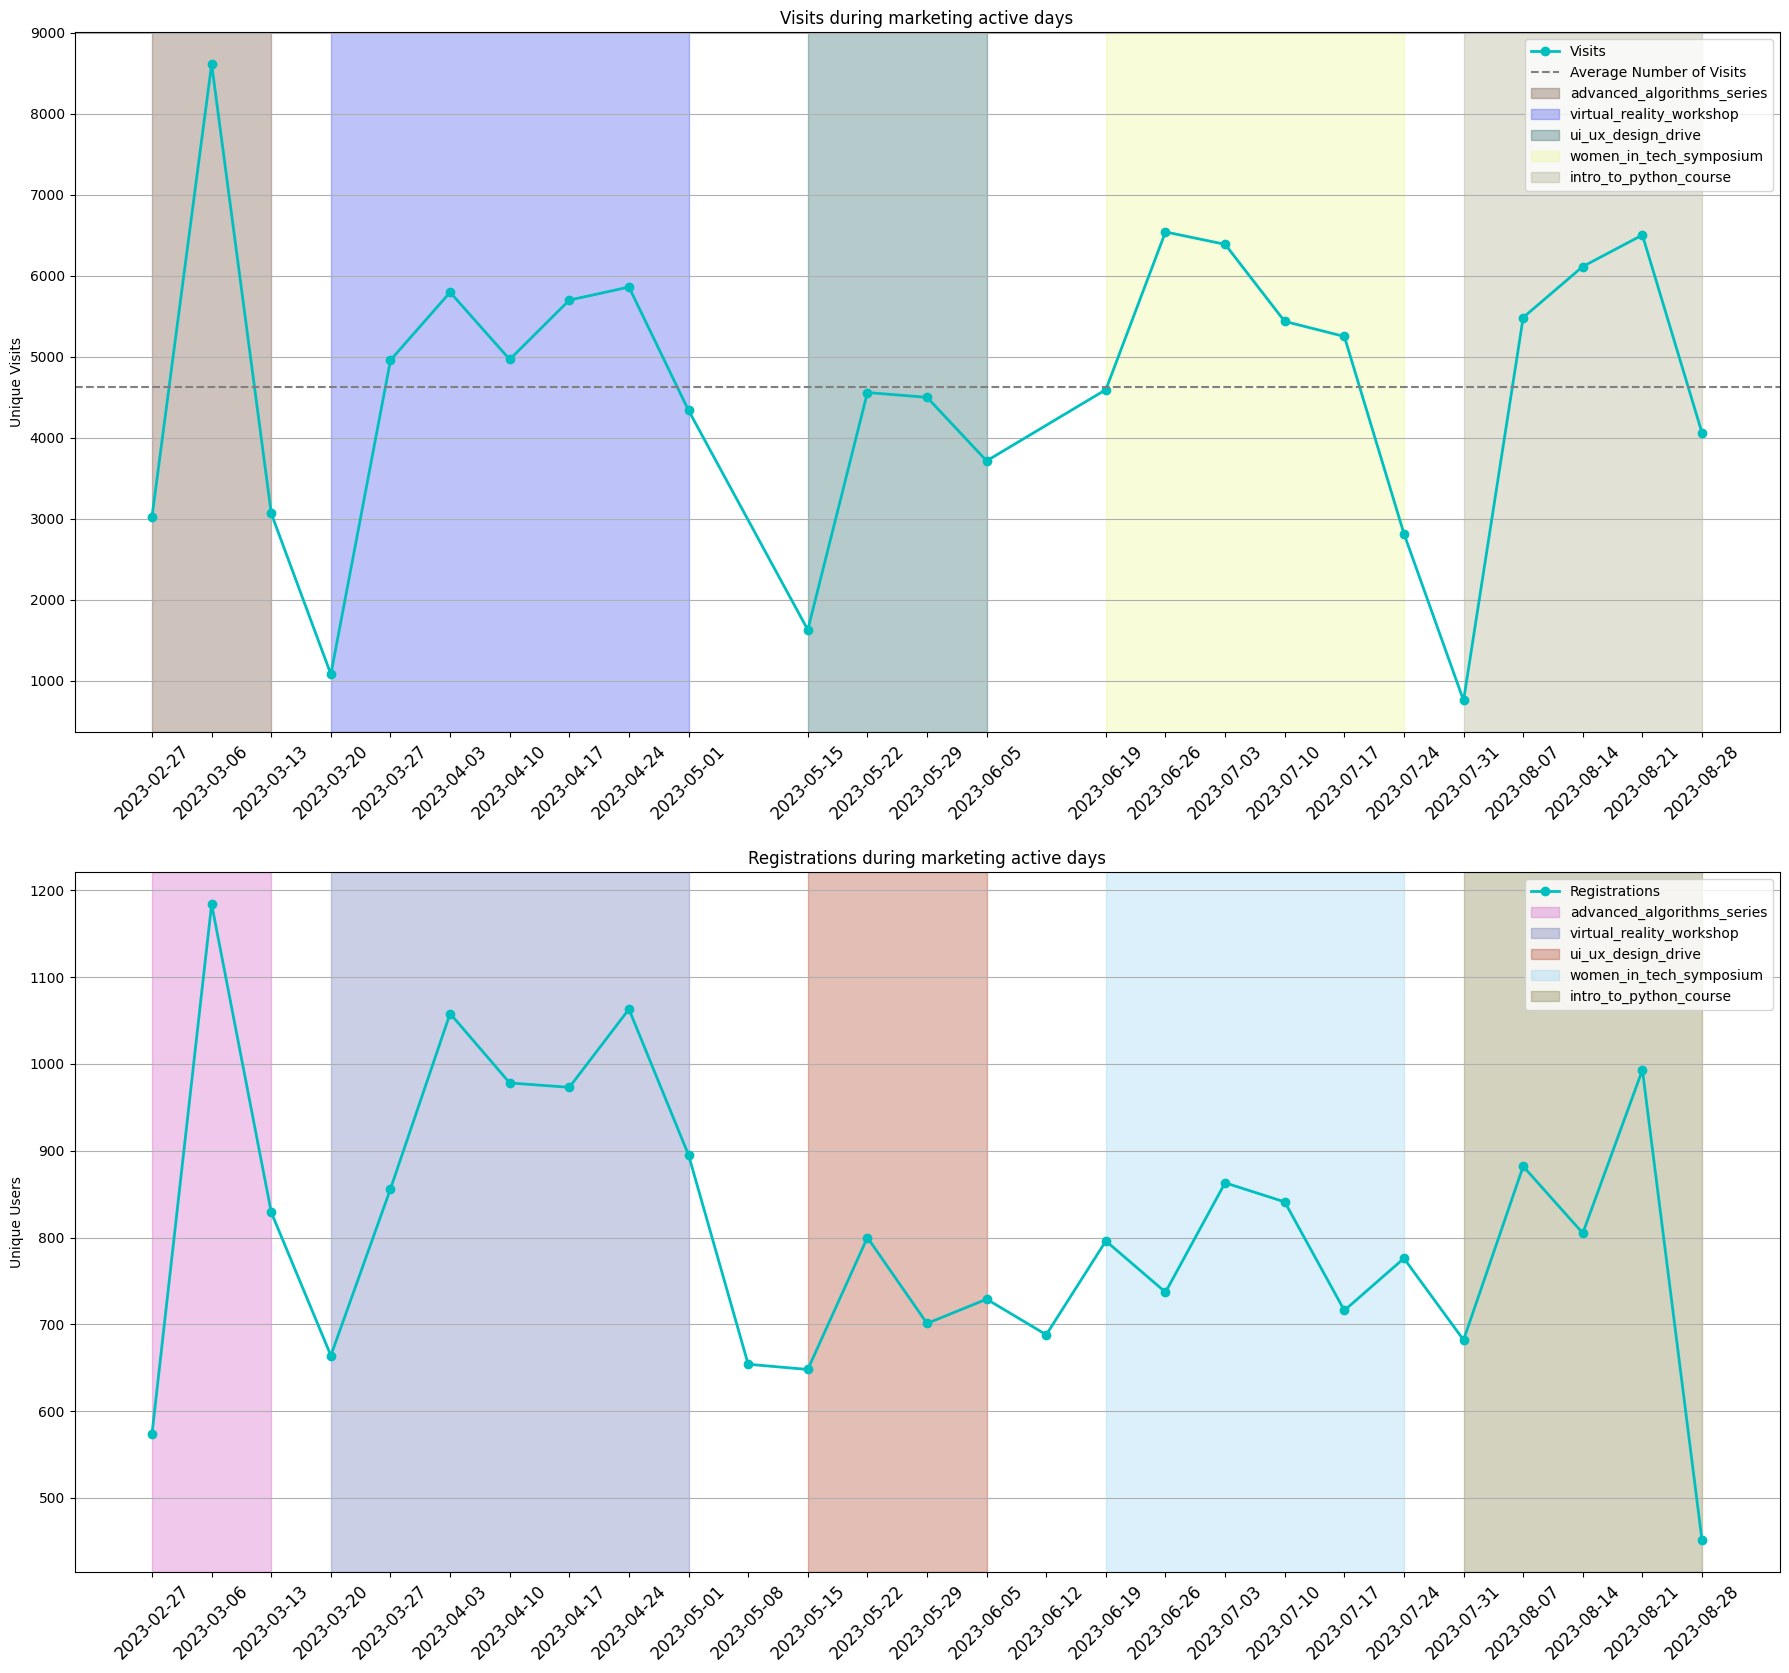

In [65]:
def vis_regist_campaign_chart(df):
    fig, axes = plt.subplots(2, 1, figsize=(22,20))
    visits_campaign = df.groupby(['date_week'])['visits'].sum().reset_index()
    x = visits_campaign['date_week']
    y = visits_campaign['visits']
    axes[0].plot(x, y,
            marker="o",
            c="c",
            label='Visits',
            linewidth=2,
            markersize=6)
    avg_visits = df['visits'].mean()
    axes[0].axhline(y=avg_visits, color='gray', linestyle='dashed', label='Average Number of Visits')
    ads_started = periods_of_ads['start_date'].to_list()
    ads_ended = periods_of_ads['end_date'].to_list()
    for i in range(len(ads_started)):
        axes[0].axvspan(ads_started[i], ads_ended[i], alpha=0.3, color=np.random.rand(3,), label=periods_of_ads['utm_campaign'].to_list()[i])
    axes[0].set_title('Visits during marketing active days')
    axes[0].set_ylabel('Unique Visits')
    axes[0].set_xticks(visits_campaign['date_week'])
    axes[0].set_xticklabels(visits_campaign['date_week'], fontsize=12, rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y')
    registr_campaign = weekly_conv_platform.groupby(['date_week'])['registrations'].sum().reset_index()
    x3 = registr_campaign['date_week']
    y3 = registr_campaign['registrations']
    axes[1].plot(x3, y3,
            marker="o",
            c="c",
            label='Registrations',
            linewidth=2,
            markersize=6)
    avg_registrations = ads['registrations'].mean()
    for i in range(len(ads_started)):
        axes[1].axvspan(ads_started[i], ads_ended[i], alpha=0.3, color=np.random.rand(3,), label=periods_of_ads['utm_campaign'].to_list()[i])
    axes[1].set_title('Registrations during marketing active days')
    axes[1].set_ylabel('Unique Users')
    axes[1].set_xticks(registr_campaign['date_week'])
    axes[1].set_xticklabels(registr_campaign['date_week'], fontsize=12, rotation=45)
    axes[1].legend()
    axes[1].grid(axis='y')
    plt.savefig(f"./charts/Visits_and_registrations_chart.png")
vis_regist_campaign_chart(ads_week)

### Дополнительные вычисления

##### Стоимость рекламных кампаний

In [66]:
def aggregate_ads_by_campaign(ads):
    aggregated_ads = ads.groupby('utm_campaign')['cost'].sum().reset_index()

    return aggregated_ads

aggregated_ads = aggregate_ads_by_campaign(ads_week)
aggregated_ads

,utm_campaign,cost
0,advanced_algorithms_series,8472
1,intro_to_python_course,14070
2,ui_ux_design_drive,12627
3,virtual_reality_workshop,27093
4,women_in_tech_symposium,20340


##### Общее количество визитов

In [67]:
def total_visits_over_time(df):
    df_cleaned = df.copy()
    df_cleaned['visit_dt'] = pd.to_datetime(df_cleaned['datetime'])
    df_cleaned = df_cleaned.sort_values(by='visit_dt')
    df_cleaned['user_agent'] = df_cleaned['user_agent'].fillna("")
    df_cleaned = df_cleaned[~df_cleaned['user_agent'].str.contains('bot')]
    df_cleaned['platform'] = df_cleaned['platform'].str.strip("'")
    df_cleaned['date_group'] = df_cleaned['visit_dt'].dt.to_period('D').dt.start_time.dt.date
    total_visits = df_cleaned['visit_id'].nunique()
    return total_visits

total_visits = total_visits_over_time(visits_df)
total_visits


138703

In [68]:
def average_visits_per_day(df_visits):
    df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
    df_visits['date_group'] = df_visits['datetime'].dt.to_period('D').dt.start_time.dt.date
    avg_visits_per_day = df_visits.groupby('date_group')['visit_id'].count().mean()
    return avg_visits_per_day

average_visits_per_day = average_visits_per_day(visits_df)
average_visits_per_day

1407.1808510638298

In [69]:
cost = ads['cost'].sum()
cost


82602